In [ ]:
!mkdir ~/.kaggle
!mv /content/kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d splcher/animefacedataset

100% 393M/395M [00:10<00:00, 44.2MB/s]
100% 395M/395M [00:10<00:00, 39.9MB/s]


Распаковка датасета

In [ ]:
import zipfile

zip_path = "/content/animefacedataset.zip"
extract_dir = "/content"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

Импорты


In [4]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

In [ ]:
data_path = '/content/animefacedataset'

In [44]:
image_size = 64
batch_size = 64
mean, std = (0.5,0.5,0.5), (0.5, 0.5, 0.5)
# Некоторые константы

In [ ]:
transform = T.Compose(
    [
        T.Resize(image_size),
        T.CenterCrop(image_size),
        T.ToTensor(),
        T.Normalize(mean, std)
    ]
)
# Предобработка

Создадим даталоадер

In [ ]:
train_if = ImageFolder(data_path, transform=transform)

In [ ]:
train_dl = DataLoader(train_if, batch_size, shuffle=True, num_workers=2)

Функции для отображения результатов

In [29]:
def denorm(img_tensors):
    return img_tensors * mean[1] + std[0]

In [41]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(images[:nmax]), nrow=8).permute(1, 2, 0))
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

Посмотрим пакет

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


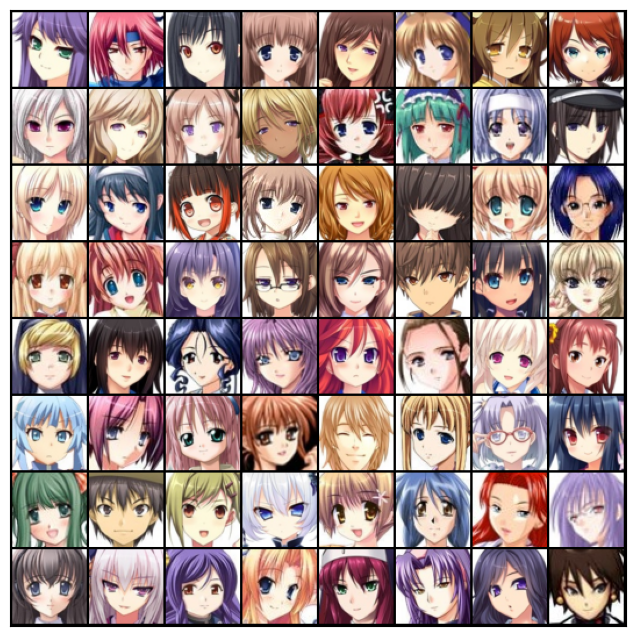

In [ ]:
show_batch(train_dl)

Создадим device

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
class DeviceDataLoader():
    """Сделаем удобный дата лоадер для загрузки на гпу"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Здесь оно загрузит данные на гпу"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """А здесь покажет количество батчей"""
        return len(self.dl)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device) # Экземпляр даталоадера

In [3]:
import torch.nn as nn

Дискриминатор

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False)
        # Выйдет 64x32x32
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.LeakyReLU(0.2, inplace=True)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False)
        # Выйдет 128x16x16
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.LeakyReLU(0.2, inplace=True)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False)
        # Выйдет 256x8x8
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.LeakyReLU(0.2, inplace=True)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False)
        # Выйдет 512x4x4
        self.bn4 = nn.BatchNorm2d(512)
        self.relu4 = nn.LeakyReLU(0.2, inplace=True)

        self.conv5 = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False)
        # Выйдет 1x1x1
        self.flatten = nn.Flatten()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.relu4(self.bn4(self.conv4(x)))
        x = self.conv5(x)
        x = self.flatten(x)
        x = self.sigmoid(x)

        return x

In [ ]:
discriminator = Discriminator()


In [ ]:
discriminator = discriminator.to(device=device)

Генератор


In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_size):
        super(Generator, self).__init__()

        # Вход - (размер скрытого состояния)x1x1, в нашем случае 128x1x1

        self.conv_transpose1 = nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False)
        # Выход - 512x4x4
        self.bn1 = nn.BatchNorm2d(512)
        self.relu1 = nn.ReLU(True)

        self.conv_transpose2 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False)
        # Выход - 256x8x8
        self.bn2 = nn.BatchNorm2d(256)
        self.relu2 = nn.ReLU(True)

        self.conv_transpose3 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False)
        # Выход - 128x8x8
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(True)

        self.conv_transpose4 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False)
        # Выход - 64x32x32
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU(True)

        self.conv_transpose5 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False)
        # Выход - 3x64x64
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu1(self.bn1(self.conv_transpose1(x)))
        x = self.relu2(self.bn2(self.conv_transpose2(x)))
        x = self.relu3(self.bn3(self.conv_transpose3(x)))
        x = self.relu4(self.bn4(self.conv_transpose4(x)))
        x = self.tanh(self.conv_transpose5(x))

        return x


In [ ]:
latent_size = 128
generator = Generator(latent_size=latent_size)
generator = generator.to(device=device)

Тренируем дискриминатор

In [ ]:
import torch.nn.functional as F

In [ ]:
def train_discriminator(real_images, opt_d):
    # Обнуление градиента оптимизатора
    opt_d.zero_grad()
    y_preds = discriminator(real_images)
    y_real = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(y_preds, y_real)
    real_score = torch.mean(y_preds).item()

    # Создадим фейковые изображения
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Пропустим через модель и снова оценим
    y_real = torch.zeros(fake_images.size(0), 1, device=device)
    y_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(y_preds, y_real)
    fake_score = torch.mean(y_preds).item()

    # Обновим веса
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # Обнулим градиенты
    opt_g.zero_grad()

    # Создадим фейковые изображения
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Обман дискриминатора
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    # Снова обновим веса
    loss.backward()
    opt_g.step()

    return loss.item()

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
from torchvision.utils import save_image
import os

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
LATENT = torch.randn(64, latent_size, 1, 1, device=device)
# Набор векторов для проверки генератора в каждой эпохе

In [ ]:
num_epochs = 15
learning_rate = 0.0002 # гиперпараметры

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    # Списки для сохранения потерь

    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    # Оптимизаторы для дискриминатора и для генератора

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl): # Перебираем батч
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d) # Обучаем дискриминатор
            loss_g = train_generator(opt_g) # Обучаем генераотр
        losses_g.append(loss_g)
        losses_d.append(loss_d) # Сохраним потери
        real_scores.append(real_score)
        fake_scores.append(fake_score) # Добавим скоры
        print(f"Epoch {epoch+1}/{epochs} loss_g: {loss_g}, loss_d: {loss_d}, real_score: {real_score}, fake_score: {fake_score}")

        # Выведем информацию об прошедшей эпохе
        save_samples(epoch+start_idx, LATENT, show=True)

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
!pip install --upgrade Pillow

In [ ]:
history = fit(num_epochs, learning_rate)

Output hidden; open in https://colab.research.google.com to view.

In [47]:
!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 45.9 MB/s eta 0:00:00


In [48]:
import torch.onnx as onnx

model = generator

# Создание фиктивного входного тензора
dummy_input = LATENT

# Сохранение модели в формате ONNX
onnx_file_path = "generator.onnx"
torch.onnx.export(model, dummy_input, onnx_file_path, verbose=True)

Развертывание модели

In [39]:
!pip install gradio

  Attempting uninstall: typer
    Found existing installation: typer 0.9.4
    Uninstalling typer-0.9.4:
      Successfully uninstalled typer-0.9.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 3.7.4 requires typer<0.10.0,>=0.3.0, but you have typer 0.12.3 which is incompatible.
weasel 0.3.4 requires typer<0.10.0,>=0.3.0, but you have typer 0.12.3 which is incompatible.


In [40]:
import gradio as gr

In [44]:
def generate_faces():
    # Генерация случайного шумового вектора размером 128x1x1
    noise = torch.randn(1, 128, 1, 1)
    generated_faces = model.generator(noise)
    generated_faces = make_grid(generated_faces.detach().cpu(), nrow=1, normalize=True)
    generated_faces = T.ToPILImage()(generated_faces)

    return generated_faces

Не сработало

In [ ]:
# iface = gr.Interface(fn=generate_faces,inputs="button", outputs="image", title="Генератор лиц")

# # Запуск интерфейса
# iface.launch()

Закинем модель на гугл диск

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [50]:
import shutil

model_path = "/content/generator.onnx"
target_path = "/content/drive/MyDrive/generator.onnx"
shutil.copyfile(model_path, target_path)

print("Успешно")

Модель успешно загружена на Google Диск.


Вот тут я потерял изображения с каждой эпохи, я удалил папку случайно с диска, а она была не скопирована а перенесена, тоесть я удалил единственную. Зато остались некоторые которые я вручную качал

In [52]:
import shutil

model_path = "/content/generated/"
target_path = "/content/drive/MyDrive/generated/"
shutil.move(model_path, target_path)

print("Успешно")

Успешно


Тестирование

In [ ]:
!pip install onnx onnxruntime

In [17]:
import onnx
import onnxruntime

In [9]:
generator = onnx.load("/content/generator.onnx")

In [22]:
input_names = [input.name for input in generator.graph.input]
print(input_names)

['onnx::ConvTranspose_0']


In [25]:
test = torch.randn(64, 128, 1, 1, device=device)

In [47]:
sess = onnxruntime.InferenceSession('/content/generator.onnx')

input_data = torch.randn(64, 128, 1, 1, device=device)

output = sess.run(None, {'onnx::ConvTranspose_0': input_data.numpy()})

predictions = output[0]

In [49]:
predictions = torch.tensor(predictions)

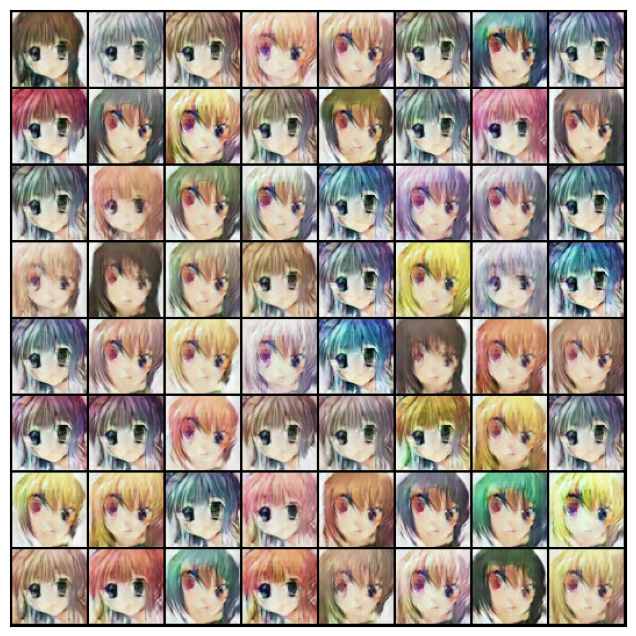

In [51]:
show_images(predictions, nmax=64)